In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange
    
from torchvision.ops import nms


In [2]:
def draw_cell_boundaries(image, cells=7):
    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(image)
    overlay_draw = ImageDraw.Draw(overlay)
    image_width, image_height = image.size
    
    fill_color = (255, 255, 128, 200)
    
    unit = image_width / cells
    for idx in range(1, cells):
        vertical_line_x = unit * idx
        overlay_draw.line([(vertical_line_x, 0), (vertical_line_x, image_height)], fill=fill_color)

    unit = image_height / cells
    for idx in range(1, cells):
        horizontal_line_y = unit * idx
        overlay_draw.line([(0, horizontal_line_y), (image_width, horizontal_line_y)], fill=fill_color)
        
    return Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
def draw_center_cell_object(image, annotator, annotation, cells=7):
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    for item in annotation:
        (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) = item
        overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        horizontal_unit = image_width / cells
        vertical_unit = image_height / cells

        class_name = annotator.labels[class_id]

        # draw center cell as red color
        cxmin = horizontal_unit * cell_idx_x
        cxmax = horizontal_unit * (cell_idx_x + 1)
        cymin = vertical_unit * cell_idx_y
        cymax = vertical_unit * (cell_idx_y + 1)
        
        draw = ImageDraw.Draw(image)
        draw.line([(cxmin, cymin), (cxmax, cymin)], fill=fill_color)
        draw.line([(cxmax, cymin), (cxmax, cymax)], fill=fill_color)
        draw.line([(cxmax, cymax), (cxmin, cymax)], fill=fill_color)
        draw.line([(cxmin, cymax), (cxmin, cymin)], fill=fill_color)
        
        cell_obj_center_x = int(cxmin + (cell_pos_x * image_width))
        cell_obj_center_y = int(cymin + (cell_pos_y * image_height))
        
        oxmin, oxmax = int(cell_obj_center_x + (width * image_width / 2)), int(cell_obj_center_x - (width * image_width / 2))
        oymin, oymax = int(cell_obj_center_y + (height * image_height / 2)), int(cell_obj_center_y - (height * image_height / 2))
        
        draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
        draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)
        
        random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
        overlay_color = (random_color_r, random_color_g, random_color_b, 90)
        overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color
        
        image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image


# TODO: redesign based on 2 predictor output
# ignore predictor with lower bbox confidence

# model output version of draw_center_cell_object
def draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.3):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    # output -> [30, 7, 7]
    cells = output.shape[1] # 1, 2 indicates cell count
    bboxes = (output.shape[0] - 20) // 5
    assert((output.shape[0] - 20) % 5 == 0) 
    
    # Organize bboxes for NMS algorithm
    bbox_coordinates = []
    bbox_scores = []
    bbox_classes = []
    for cell_idx_y in range(cells):
        for cell_idx_x in range(cells):
            for bbox_idx in range(bboxes):
                current_predictor = output[5 * (bbox_idx):5 * (bbox_idx + 1), cell_idx_y, cell_idx_x]
                (cell_pos_x, cell_pos_y, width, height, confidence) = torch.sigmoid(torch.from_numpy(current_predictor[:5])).numpy()
                class_id = np.argmax(output[5 * bboxes:, cell_idx_y, cell_idx_x])
                
                if confidence < confidence_threshold:
                    continue
                # print("sigmoided coordinates", np.array([cell_pos_x, cell_pos_y, width, height, confidence]))

                horizontal_unit = image_width / cells
                vertical_unit = image_height / cells
                
                class_name = annotator.labels[class_id]
                obj_center_x = (cell_idx_x + cell_pos_x) / cells
                obj_center_y = (cell_idx_y + cell_pos_y) / cells
                oxmin, oxmax = obj_center_x - (width / 2), obj_center_x + (width / 2)
                oymin, oymax = obj_center_y - (height / 2), obj_center_y + (height / 2)
                
                bbox_coordinates.append([oxmin, oymin, oxmax, oymax])
                bbox_scores.append(confidence)
                bbox_classes.append(class_id)
                
#     print("bbox_coordinates", bbox_coordinates)
#     print("bbox_scores", bbox_scores)
#     print("bbox_classes", bbox_classes)
                
    if len(bbox_coordinates) > 0:
        # print("[Before NMS] BBoxes:", len(bbox_coordinates))

        bbox_coordinates = torch.from_numpy(np.array(bbox_coordinates)).float()
        bbox_scores = torch.from_numpy(np.array(bbox_scores)).float()
        bbox_classes = torch.from_numpy(np.array(bbox_classes)).float()

        coordinates_indicies = nms(boxes=bbox_coordinates, scores=bbox_scores, iou_threshold=0.8)
        
#         bbox_filtered_coordinates = torch.gather(bbox_coordinates, 1, coordinates_indicies)
#         bbox_filtered_scores = torch.gather(bbox_scores, 0, coordinates_indicies)
#         bbox_filtered_classes = torch.gather(bbox_classes, 0, coordinates_indicies)

        bbox_filtered_coordinates = bbox_coordinates.index_select(0, coordinates_indicies)
        bbox_filtered_scores = bbox_scores.index_select(0, coordinates_indicies)
        bbox_filtered_classes = bbox_classes.index_select(0, coordinates_indicies).int()
        
#         print("[After NMS] BBoxes:", len(bbox_filtered_coordinates))

        for idx in range(bbox_filtered_coordinates.shape[0]):
            (xmin, ymin, xmax, ymax) = bbox_filtered_coordinates[idx].numpy()
            confidence = bbox_filtered_scores[idx].numpy()
            class_id = bbox_filtered_classes[idx].numpy()
            
            oxmin, oxmax = max(xmin * image_width, 0), min(xmax * image_width, image_width - 1)
            oymin, oymax = max(ymin * image_height, 0), min(ymax * image_height, image_height - 1)
            
            cell_obj_center_x, cell_obj_center_y = int(oxmin + (oxmax - oxmin) / 2), int(oymin + (oymax - oymin) / 2)

            class_name = annotator.labels[class_id]

            overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
            overlay_draw = ImageDraw.Draw(overlay)

            draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
            
            draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)

            random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
            overlay_color = (random_color_r, random_color_g, random_color_b, 90)
            overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color

            image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image

In [3]:
# Test code

# samples = 4

# for _ in range(samples):
#     random_sample = randrange(len(annotations))
#     filepath, annotation = annotations[random_sample]

#     image = Image.open(filepath)
#     image = draw_cell_boundaries(image, cells=7)
#     image = draw_center_cell_object(image, annotator, annotation, cells=7)
    
#     plt.figure(figsize=(15, 15))
#     plt.imshow(np.asarray(image))

# Prepare dataset and training
- Create random 5-image batch and pass it through model.
- We will evaluate loss via result image and intermediate output console

In [4]:
%matplotlib inline

from maintrainer.dataset import VOCYOLOAnnotator, VOCYolo

annotator = VOCYOLOAnnotator(
#     annotation_root=r'C:\Dataset\VOCdevkit\VOC2008\Annotations',
#     image_root=r'C:\Dataset\VOCdevkit\VOC2008\JPEGImages'
    annotation_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/Annotations',
    image_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

print(annotator.labels)

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: /media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages/2007_000256.jpg
Annotation[1]: [[0, 3, 3, 0.07042857142857145, 0.0495626822157435, 0.966, 0.3965014577259475]]
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [5]:
import torchvision.transforms
from torchvision.transforms import *

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ])
)

inline_transform = transforms.Normalize(
    mean=[0.4547857, 0.4349471, 0.40525291],
    std=[0.12003352, 0.12323549, 0.1392444]
)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)

In [6]:
def draw_center_cell_object_label(image, annotator, label):
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    # label -> [25, 7, 7]
    cells = label.shape[1] # 1, 2 indicates cell count
    
    for cell_idx_y in range(cells):
        for cell_idx_x in range(cells):
            # ignore predictor with no bbox confidence
            if label[4, cell_idx_y, cell_idx_x] == 0:
                continue
                
            # (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) = item
            current_predictor = label[:, cell_idx_y, cell_idx_x]
            (cell_pos_x, cell_pos_y, width, height) = current_predictor[:4]
            class_id = np.argmax(current_predictor[5:])
            
            overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
            overlay_draw = ImageDraw.Draw(overlay)

            horizontal_unit = image_width / cells
            vertical_unit = image_height / cells

            class_name = annotator.labels[class_id]

            # draw center cell as red color
            cxmin = horizontal_unit * cell_idx_x
            cxmax = horizontal_unit * (cell_idx_x + 1)
            cymin = vertical_unit * cell_idx_y
            cymax = vertical_unit * (cell_idx_y + 1)

            draw = ImageDraw.Draw(image)
            draw.line([(cxmin, cymin), (cxmax, cymin)], fill=fill_color)
            draw.line([(cxmax, cymin), (cxmax, cymax)], fill=fill_color)
            draw.line([(cxmax, cymax), (cxmin, cymax)], fill=fill_color)
            draw.line([(cxmin, cymax), (cxmin, cymin)], fill=fill_color)

            cell_obj_center_x = int(cxmin + (cell_pos_x * image_width))
            cell_obj_center_y = int(cymin + (cell_pos_y * image_height))

            oxmin, oxmax = int(cell_obj_center_x + (width * image_width / 2)), int(cell_obj_center_x - (width * image_width / 2))
            oymin, oymax = int(cell_obj_center_y + (height * image_height / 2)), int(cell_obj_center_y - (height * image_height / 2))

            draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
            draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)

            random_color_r, random_color_g, random_color_b = 255, 255, 255
            overlay_color = (random_color_r, random_color_g, random_color_b, 90)
            overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=None, outline=(0, 0, 255), width=2)  # draw object in random color

            image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image

In [ ]:
bunch_of_batch = []
for i, item in enumerate(train_dataloader):
    if i >= 4:
        break
    bunch_of_batch.append(item)

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Label based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image[:1, :, :, :])
    label = torch.squeeze(label[:1, :, :, :])
    
    image = (image.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.cpu().numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object_label(image, annotator, label)
    ax.imshow(np.array(image))
    
plt.show()

In [8]:
def do_visualization(title = None, confidence_threshold = 0.8):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    
    batched_image = torch.cat([image[:1, :, :, :].cuda(non_blocking=True) for image, label in bunch_of_batch], 0)
    batched_label = torch.cat([label[:1, :, :, :] for image, label in bunch_of_batch], 0)
    
    output = model(batched_image).detach().cpu()
    output_images = []
    for i in range(output.shape[0]):
        output_images.append(output[i:i+1, :, :, :])
    
    for i, output in enumerate(output_images):
        ax = fig.add_subplot(2, 2, i + 1)

        image = torch.squeeze(batched_image[i].cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=confidence_threshold)
        ax.imshow(np.array(image))
    model.train()

    plt.show()

In [9]:
from maintrainer.loss import YoloLoss
from model import YOLOv1, YOLOv1Pretrainer
import random
import os

# PRETRAINED_WEIGHT = r'C:\Workspace\study-projects\yolov1-torch\prepare-torch\.pretrained\2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'
PRETRAINED_WEIGHT = '.checkpoints/2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'

if not os.path.isfile(PRETRAINED_WEIGHT):
    print("Pretrained weight file %s not found!" % args.pretrained)
    exit(-1)

checkpoint = torch.load(PRETRAINED_WEIGHT)
# c_epoch = checkpoint['epoch'] + 1
c_model_state_dict = checkpoint['model_state_dict']
# c_optimizer_state_dict = checkpoint['optimizer_state_dict']
# c_loss = checkpoint['loss']

pretrainer = YOLOv1Pretrainer(classes=1000)
pretrainer.load_state_dict(c_model_state_dict)
model = YOLOv1(pretrainer).cuda().float()
del pretrainer

YOLOv1: Loaded pretrained weights from Pretrainer
YOLOv1: Disabled pretrained parameter gradients


In [10]:
# from time import sleep

# # Testing loss with given pseudo output!
# criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# # batched_image = torch.cat([image for image, label in bunch_of_batch], 0)
# # batched_label = torch.cat([label for image, label in bunch_of_batch], 0)

# losses = []
# class_accuracies = []
# class_top_5_accuracies = []

# batched_image = torch.cat([image for (image, label) in bunch_of_batch], 0)
# batched_label = torch.cat([label for (image, label) in bunch_of_batch], 0)

# print(batched_image.shape)
# print(batched_label.shape)

# for epoch in range(1000):
# #     random.shuffle(bunch_of_batch)
    
# #     if epoch % 5 == 0:
# #         for g in optimizer.param_groups:
# #             g['lr'] *= 0.95
#     if epoch % 100 == 0:
#         do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']))
            
# #     if epoch % 10 == 0:
# #         do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']))

#     if batched_image.device.type != 'cuda':
#         batched_image = batched_image.cuda(non_blocking=True)
#         batched_label = batched_label.cuda(non_blocking=True)
        
#     output = model(batched_image)
#     loss = criterion(output, batched_label)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

#     with torch.no_grad():
#         model.eval()
#         class_accuracy = torch.sum(
#             torch.eq(
#                 torch.argmax(torch.sigmoid(output[:, -20:, :, :]), dim=1),
#                 torch.argmax(batched_label, dim=1)
#             ) * (batched_label[:, 4, :, :] == 1)
#         ) / torch.sum(batched_label[:, 4:5, :, :])
#         class_top_5_accuracy = torch.sum(
#             torch.any(
#                 torch.eq(
#                     torch.argsort(torch.sigmoid(output[:, -20:, :, :]), dim=1)[:, -5:, :, :],
#                     torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
#                 ),
#                 dim=1
#             ) * (batched_label[:, 4, :, :] == 1)
#         ) / torch.sum(batched_label[:, 4:5, :, :])
#         losses.append(loss.item())
#         class_accuracies.append(class_accuracy.item())
#         class_top_5_accuracies.append(class_top_5_accuracy.item())
#         print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f" % (epoch, losses[-1], class_accuracies[-1], class_top_5_accuracies[-1]))
#         model.train()

# #     output = model(batched_image)
# #     loss = criterion(output, batched_label)
# #     loss.backward()
# #     optimizer.step()
# #     optimizer.zero_grad(set_to_none=True)

# #     with torch.no_grad():
# #         losses.append(loss.item())

NewYoloLossV9 (CUDA not supported for now)
Begin Training (Batch=32, LR=0.000007) 


  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([3, 448, 448])
torch.Size([3, 448, 448])
torch.Size([3, 448, 448])
torch.Size([3, 448, 448])


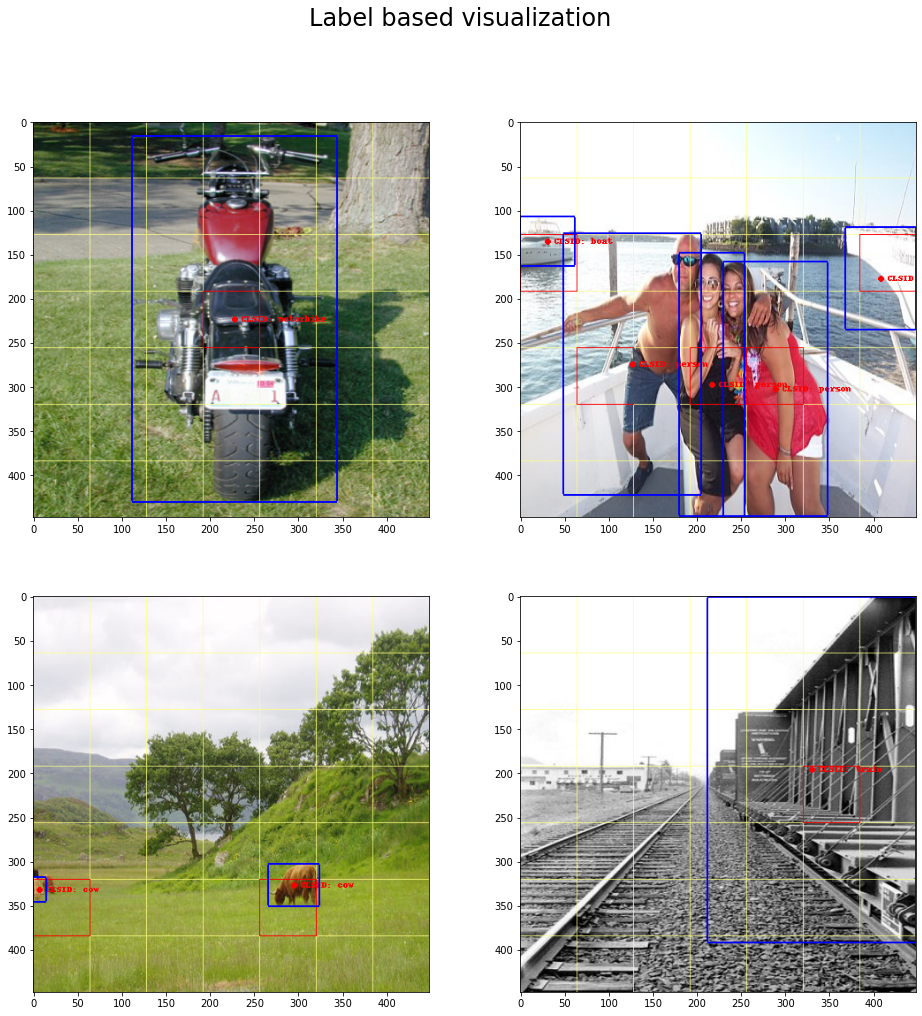

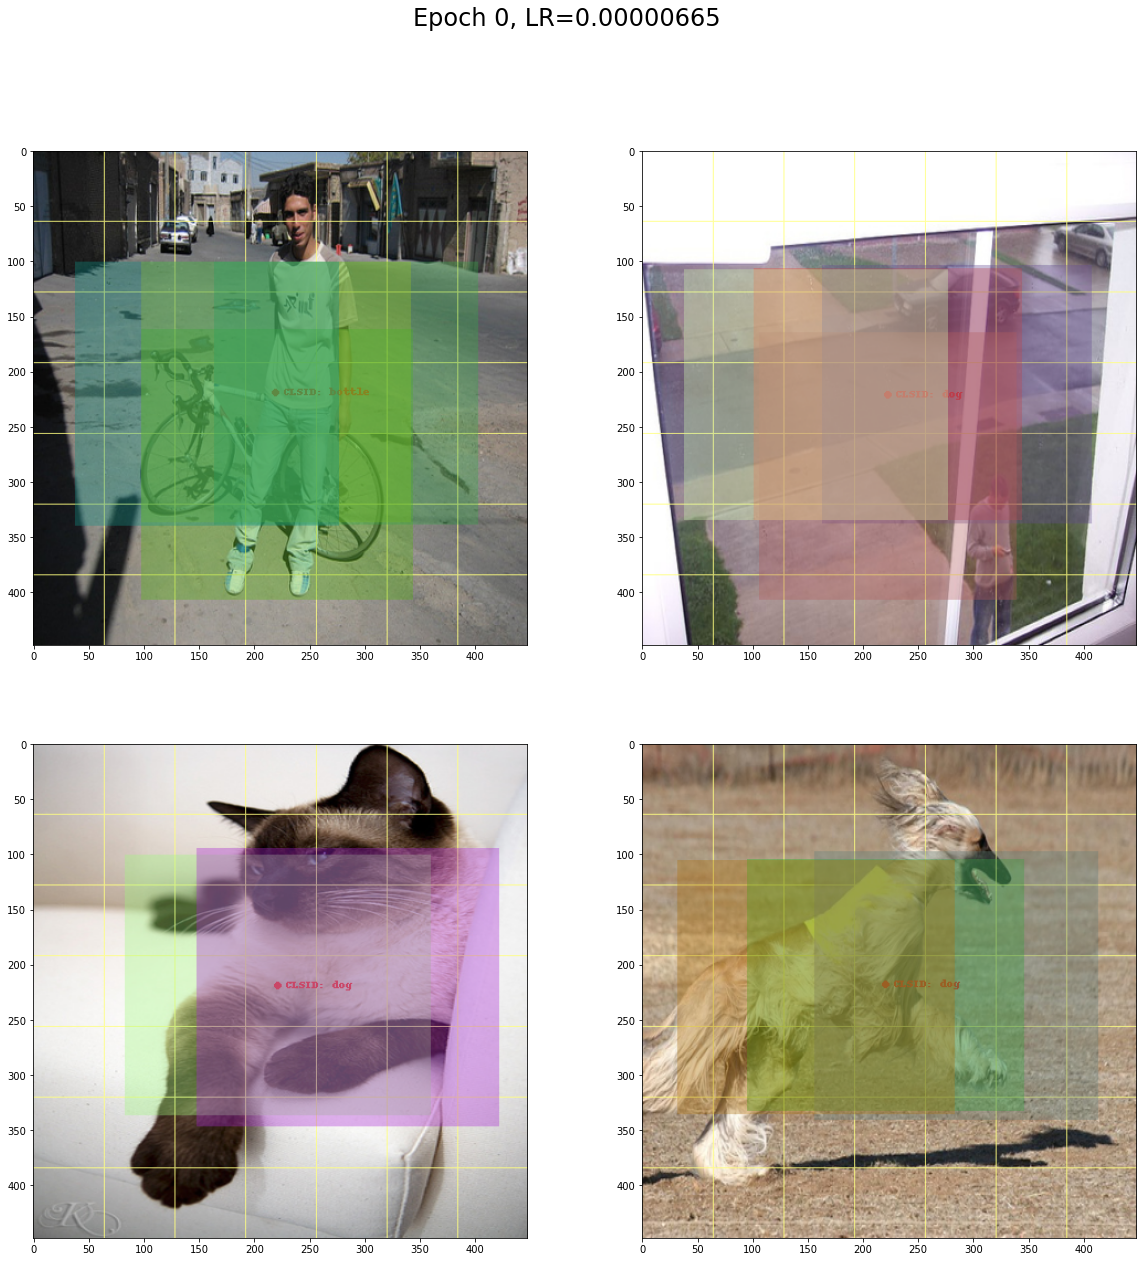

  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([3, 448, 448])
torch.Size([3, 448, 448])
torch.Size([3, 448, 448])
torch.Size([3, 448, 448])


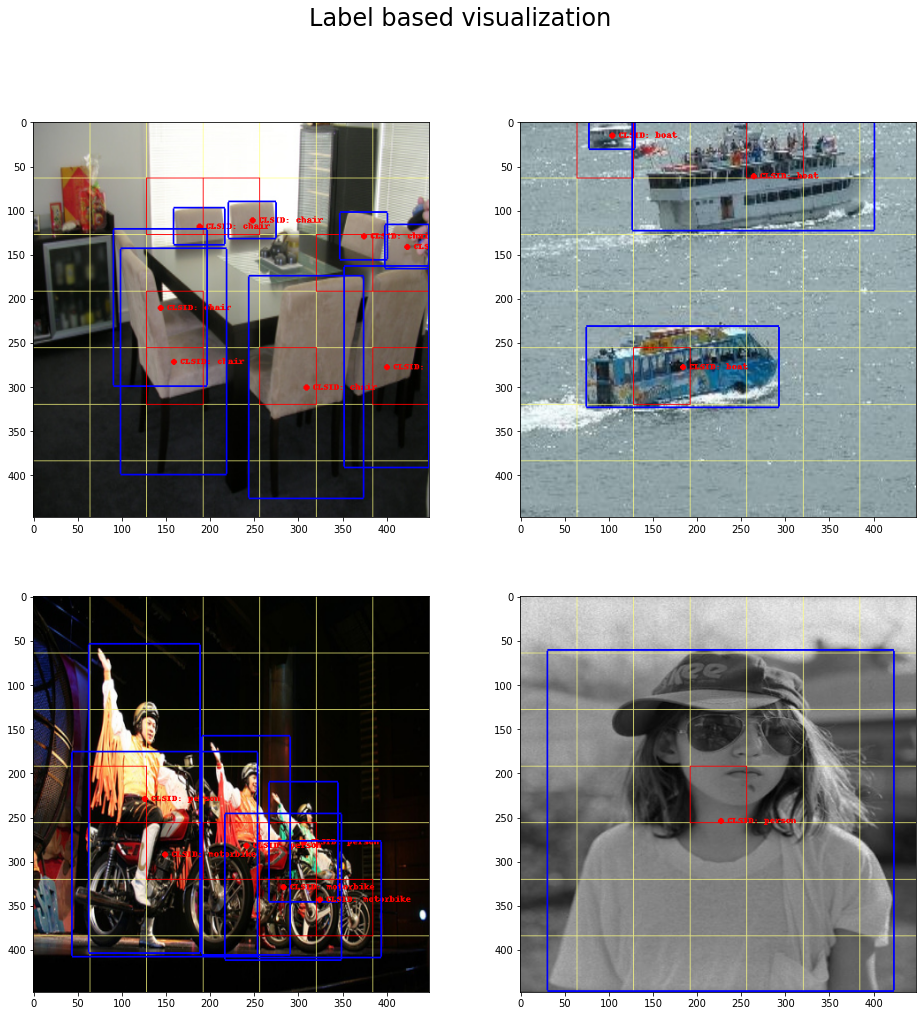

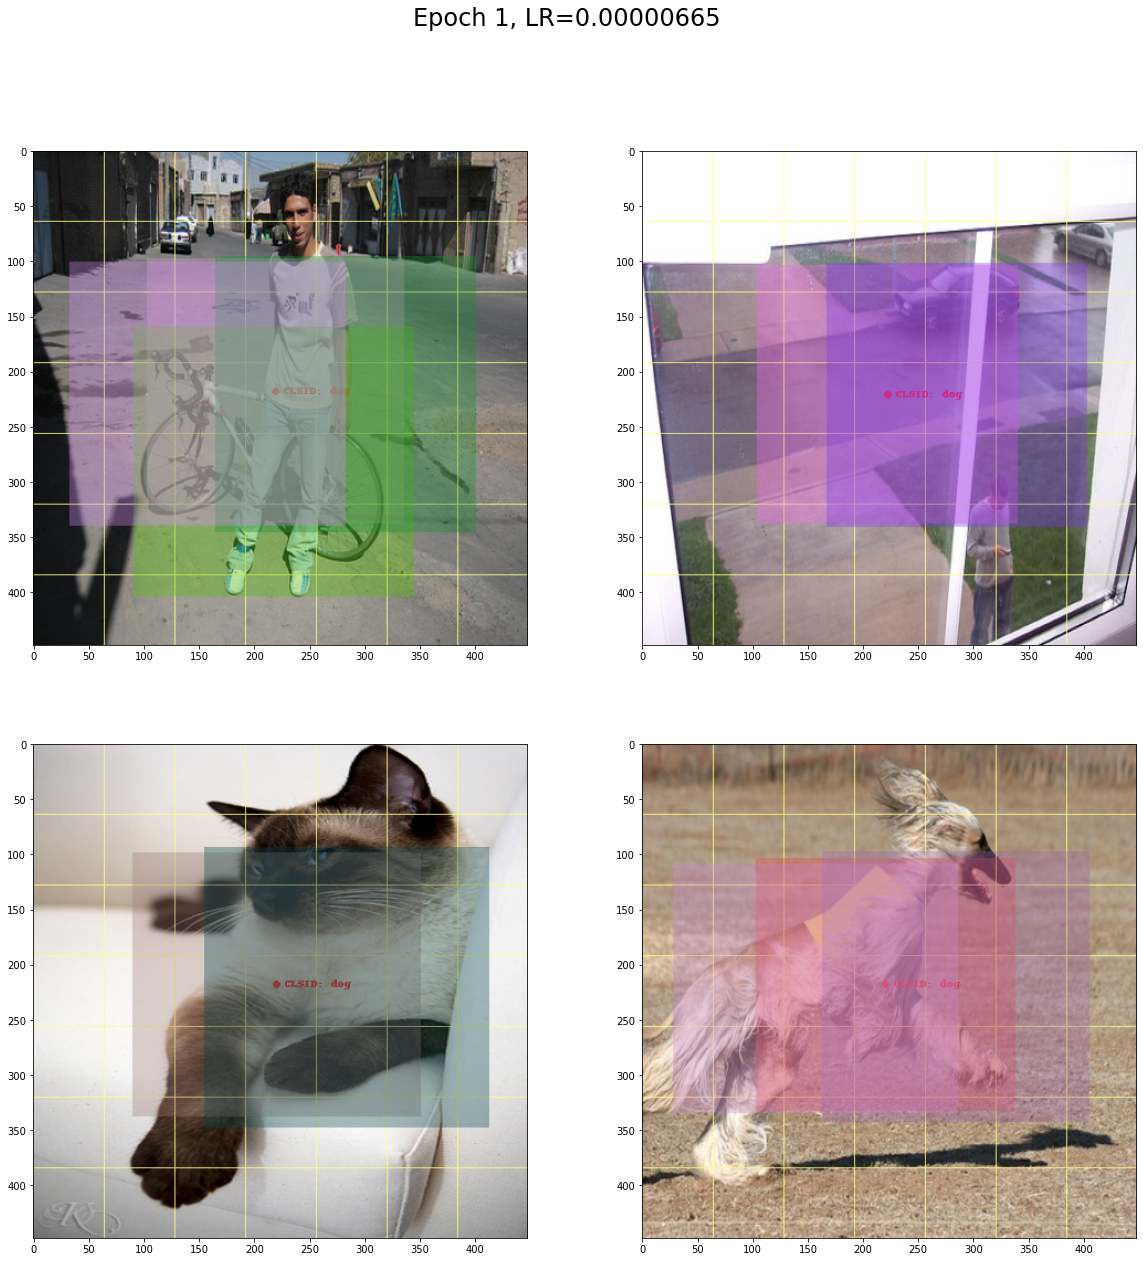

KeyboardInterrupt: 

In [17]:
from time import sleep
from tqdm.auto import tqdm

# Testing loss with given pseudo output!
criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-6)  # 0.00001, 7e-6

losses = []
class_accuracies = []
class_top_5_accuracies = []

print("Begin Training (Batch=%d, LR=%.6f) " % (batch_size, optimizer.param_groups[0]['lr']))
for epoch in range(150):
    tr = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    )
    if epoch % 5 == 0:
        for g in optimizer.param_groups:
            g['lr'] *= 0.95
            
    for i, (batched_image, batched_label) in tr:
        if i == 0:
            fig = plt.figure(figsize=(16, 16))
            fig.suptitle("Label based visualization", fontsize=24)
            for i in range(4):
                image = batched_image[i, :, :, :]
                label = batched_label[i, :, :, :]
                
                ax = fig.add_subplot(2, 2, i + 1)
                image = torch.squeeze(image)
                label = torch.squeeze(label)
                print(image.shape)

                image = (image.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
                label = label.cpu().numpy()

                image = Image.fromarray(image)
                image = draw_cell_boundaries(image)
                image = draw_center_cell_object_label(image, annotator, label)
                ax.imshow(np.array(image))

            plt.show()
            do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']), confidence_threshold = 0.4)

        if batched_image.device.type != 'cuda':
            batched_image = inline_transform(batched_image).cuda(non_blocking=True)
            batched_label = batched_label.cuda(non_blocking=True)

        output = model(batched_image)
        loss = criterion(output, batched_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            model.eval()
            class_accuracy = torch.sum(
                torch.eq(
                    torch.argmax(torch.softmax(output[:, -20:, :, :], dim=1), dim=1),
                    torch.argmax(batched_label, dim=1)
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            class_top_5_accuracy = torch.sum(
                torch.any(
                    torch.eq(
                        torch.argsort(torch.softmax(output[:, -20:, :, :], dim=1), dim=1)[:, -5:, :, :],
                        torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
                    ),
                    dim=1
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            losses.append(loss.item())
            class_accuracies.append(class_accuracy.item())
            class_top_5_accuracies.append(class_top_5_accuracy.item())
            # print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f" % (epoch, losses[-1], class_accuracies[-1], class_top_5_accuracies[-1]))
            tr.set_description("Epoch %d: Loss %.6f Acc %.1f%% AccT5 %.1f%%" % (epoch, np.average(losses), np.average(class_accuracies) * 100, np.average(class_top_5_accuracies) * 100))
            model.train()


In [ ]:
##
## Pseudo label convergence test
##

from time import sleep

# Testing loss with given pseudo output!
criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# batched_image = torch.cat([image for image, label in bunch_of_batch], 0)
# batched_label = torch.cat([label for image, label in bunch_of_batch], 0)

losses = []
class_accuracies = []
class_top_5_accuracies = []

batched_image = torch.cat([image for (image, label) in bunch_of_batch], 0)
batched_label = torch.cat([label for (image, label) in bunch_of_batch], 0)

for epoch in range(1000):
#     random.shuffle(bunch_of_batch)
    
#     if epoch % 5 == 0:
#         for g in optimizer.param_groups:
#             g['lr'] *= 0.95
    if epoch % 10 == 0:
        do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']))
            
#     if epoch % 10 == 0:
#         do_visualization(title="Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']))

    label_batches = batched_image.shape[0]
    pseudo_label = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(np.array([
        #x, y, w, h, c, classes
        # 0.0, 0.0, 1.38629, 0.40547, 0.6, # 0.5, 0.5, 0.8, 0.6, 0.6,
        # -2.197224, 2.197225, -0.405465, -1.3862894, 0.1, # 0.1, 0.9, 0.4, 0.2, 0.1,
        0.1, 0.4, 0.12, 0.12, 1.0, # All slightly left middle and forms a boxed structure
        # Class ID is 5 (bus)
        0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    ], dtype=np.float32)).repeat(label_batches, 1), 2), 3).repeat(1, 1, 7, 7)
    
#     pseudo_label_empty = torch.zeros(label_batches - 1, 25, 7, 7)
    
#     pseudo_label = torch.cat([pseudo_label, pseudo_label_empty], dim=0)

    if batched_image.device.type != 'cuda':
        batched_image = inline_transform(batched_image).cuda(non_blocking=True)
        batched_label = batched_label.cuda(non_blocking=True)
    
    output = model(batched_image)
    loss = criterion(output, pseudo_label.cuda())
#     loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

    with torch.no_grad():
        model.eval()
        class_accuracy = torch.sum(
            torch.eq(
                torch.argmax(torch.sigmoid(output[:, -20:, :, :]), dim=1),
                torch.argmax(batched_label, dim=1)
            ) * (batched_label[:, 4, :, :] == 1)
        ) / torch.sum(batched_label[:, 4:5, :, :])
        class_top_5_accuracy = torch.sum(
            torch.any(
                torch.eq(
                    torch.argsort(torch.sigmoid(output[:, -20:, :, :]), dim=1)[:, -5:, :, :],
                    torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
                ),
                dim=1
            ) * (batched_label[:, 4, :, :] == 1)
        ) / torch.sum(batched_label[:, 4:5, :, :])
        losses.append(loss.item())
        class_accuracies.append(class_accuracy.item())
        class_top_5_accuracies.append(class_top_5_accuracy.item())
        print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f" % (epoch, losses[-1], class_accuracies[-1], class_top_5_accuracies[-1]))
        model.train()

#     output = model(batched_image)
#     loss = criterion(output, batched_label)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

#     with torch.no_grad():
#         losses.append(loss.item())